In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 
from sklearn.model_selection import train_test_split
import torchvision.models as models

from Sources.callbacks_2classes import plot_confusion_matrix
from torch.nn import functional as F
from Sources.callbacks_2classes import get_true_classes
from Sources.callbacks_2classes import get_predicted_classes
from Sources.callbacks_2classes import get_classes_probs
from Sources.callbacks_2classes import callback
from Sources.data_tools import ImageDataset_2cl
from Sources.ViT.models.modeling import VisionTransformer, CONFIGS

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

labels_map_2cl = {
    "Benign": 0,
    "Malignant": 1,
}

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = ImageDataset_2cl('../Data/burnasyan_Br.csv', 'val_paths.txt', transform = transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

Using cuda device


In [3]:
# VIT
config = CONFIGS["ViT-B_16"]
vit = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
vit.head = nn.Linear(768, 2)
vit.load_state_dict(torch.load("../Logits/SavedNN/Saved_ViT_2cl/" + str(140)))
vit.eval()
vit.to(device)

# RESNET
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(2048, 2)
resnet.load_state_dict(torch.load("../Logits/SavedNN/Saved_ResNet50_2cl/" + str(30)))
resnet.eval()
resnet.to(device)
None

In [5]:
vit_classes = []
resnet_classes = []

for data in tqdm_notebook(val_dataloader, desc='computing consistency on validation'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # forward 
        with torch.no_grad():
            vit_outputs = vit(inputs)[0]
            resnet_outputs = resnet(inputs)
        
        vit_classes.append(nn.Softmax(dim=1)(vit_outputs))
        resnet_classes.append(nn.Softmax(dim=1)(resnet_outputs))

computing consistency on validation:   0%|          | 0/657 [00:00<?, ?it/s]

In [6]:
vit_preds = get_predicted_classes(vit_classes)
resnet_preds = get_predicted_classes(resnet_classes)

In [7]:
def plot_consistency_matrix(cm, class_names):

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Consistency matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 3 * 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('ViT') # true
    plt.xlabel('ResNet') # predicted
    return figure



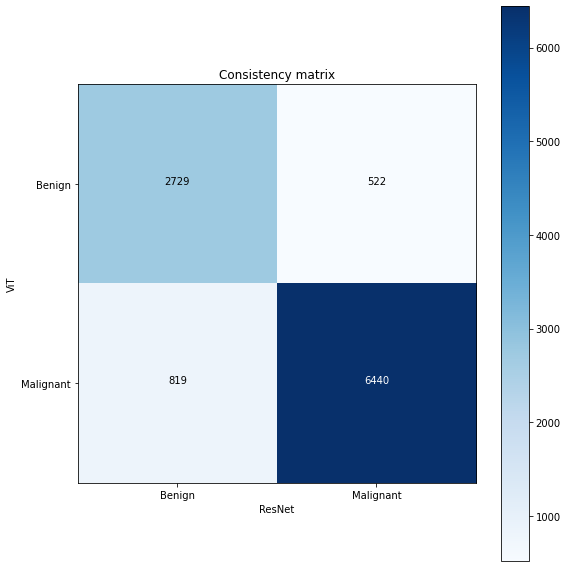

In [8]:
cm = plot_consistency_matrix(confusion_matrix(vit_preds, resnet_preds),
                             ["Benign", "Malignant"])

## TODO: 
### 4 files - ViT_Benign_ResNet_Benign; ViT_Benign_ResNet_Malignant; ViT_Malignant_ResNet_Benign; ViT_Malignant_ResNet_Malignant;